# PF7:  Aprendiendo y prediciendo a partir de un sistema dinámico con observaciones parciales y usando modelos de difusión

**Objetivo general**: Desarrollar un modelo predictor con cuantificación de la incerteza de sistemas dinámicos que aprenda a partir de observaciones parciales y ruidosas

Objetivos específicos:
- Demostrar el potencial de los modelos generativos de difusión para generar muestras sintéticas de una base de datos.
- Determinar la incerteza de una predicción utilizando modelos difusivos.
- Comparar la performance del modelo difusivo compara a una red neuronal fully connected en eventos extremos.

- Los sistemas que se pueden tomar de prototipo son:  Lorenz-63. Problema de los tres cuerpos. Péndulo doble.

In [10]:
import io
import sys

import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.patches import Circle
from scipy.integrate import odeint
from tqdm import tqdm

# Pendulum rod lengths (m), bob masses (kg).
L1, L2 = 1, 1
m1, m2 = 1, 1
# The gravitational acceleration (m.s-2).
g = 9.81


def deriv(y, t, L1, L2, m1, m2):
    """Return the first derivatives of y = theta1, z1, theta2, z2."""
    theta1, z1, theta2, z2 = y

    c, s = np.cos(theta1 - theta2), np.sin(theta1 - theta2)

    theta1dot = z1
    z1dot = (m2 * g * np.sin(theta2) * c - m2 * s * (L1 * z1 ** 2 * c + L2 * z2 ** 2) -
             (m1 + m2) * g * np.sin(theta1)) / L1 / (m1 + m2 * s ** 2)
    theta2dot = z2
    z2dot = ((m1 + m2) * (L1 * z1 ** 2 * s - g * np.sin(theta2) + g * np.sin(theta1) * c) +
             m2 * L2 * z2 ** 2 * s * c) / L2 / (m1 + m2 * s ** 2)
    return theta1dot, z1dot, theta2dot, z2dot


def calc_E(y):
    """Return the total energy of the system."""

    th1, th1d, th2, th2d = y.T
    V = -(m1 + m2) * L1 * g * np.cos(th1) - m2 * L2 * g * np.cos(th2)
    T = 0.5 * m1 * (L1 * th1d) ** 2 + 0.5 * m2 * ((L1 * th1d) ** 2 + (L2 * th2d) ** 2 +
                                                  2 * L1 * L2 * th1d * th2d * np.cos(th1 - th2))
    return T + V


# Maximum time, time point spacings and the time grid (all in s).
tmax, dt = 100, 0.01
t = np.arange(0, tmax + dt, dt)
# Initial conditions: theta1, dtheta1/dt, theta2, dtheta2/dt.
# y0 = np.array([3*np.pi/7, 0, 3*np.pi/4, 0])
y0 = np.array([np.pi * 0.1, 0, np.pi * 0.1, 0])

# Do the numerical integration of the equations of motion
y = odeint(deriv, y0, t, args=(L1, L2, m1, m2))

# Check that the calculation conserves total energy to within some tolerance.
EDRIFT = 0.05
# Total energy from the initial conditions
E = calc_E(y0)
if np.max(np.sum(np.abs(calc_E(y) - E))) > EDRIFT:
    sys.exit('Maximum energy drift of {} exceeded.'.format(EDRIFT))

# Unpack z and theta as a function of time
theta1, theta2 = y[:, 0], y[:, 2]

# Convert to Cartesian coordinates of the two bob positions.
x1 = L1 * np.sin(theta1)
y1 = -L1 * np.cos(theta1)
x2 = x1 + L2 * np.sin(theta2)
y2 = y1 - L2 * np.cos(theta2)

# Plotted bob circle radius
r = 0.05
# Plot a trail of the m2 bob's position for the last trail_secs seconds.
trail_secs = 1
# This corresponds to max_trail time points.
max_trail = int(trail_secs / dt)

In [11]:
y

array([[ 3.14159265e-01,  0.00000000e+00,  3.14159265e-01,
         0.00000000e+00],
       [ 3.14007716e-01, -3.03051257e-02,  3.14159242e-01,
        -9.44134948e-06],
       [ 3.13553351e-01, -6.05537253e-02,  3.14158888e-01,
        -7.54059136e-05],
       ...,
       [ 2.59264411e-01,  1.37847844e-01,  2.94986858e-01,
         7.00614294e-01],
       [ 2.60535665e-01,  1.16475744e-01,  3.01956423e-01,
         6.93116477e-01],
       [ 2.61595432e-01,  9.55554161e-02,  3.08845506e-01,
         6.84514376e-01]])

### Random initial states

In [19]:
n_states = 10000

ang_range1 = np.linspace(-np.pi, np.pi, n_states)
np.random.shuffle(ang_range1)
ang_range2 = np.linspace(-np.pi, np.pi, n_states)
np.random.shuffle(ang_range2)

xpos_range = np.linspace(-L1 - L2, L1 + L2, n_states)
np.random.shuffle(xpos_range)

ypos_range = np.linspace(-L1 - L2, L1 + L2, n_states)
np.random.shuffle(ypos_range)

In [20]:
y0 = np.array([ang_range1, xpos_range, ang_range2, ypos_range]).T
y0

array([[ 1.98474255,  1.66436644,  1.83078912, -0.42024202],
       [-3.10074786, -0.50145015, -1.45753059, -1.68636864],
       [-0.97933236,  0.54505451,  0.57968181, -1.01190119],
       ...,
       [ 0.60167516, -1.26232623,  2.13932437,  0.56865687],
       [ 0.13290266,  0.4630463 ,  0.24538292, -1.22872287],
       [ 0.57214124,  1.90159016,  0.65257405, -1.26192619]])

In [21]:
y = odeint(deriv, y0[0], t, args=(L1, L2, m1, m2))

In [22]:
y

array([[  1.98474255,   1.66436644,   1.83078912,  -0.42024202],
       [  2.00094705,   1.57678835,   1.8265674 ,  -0.42440995],
       [  2.01628354,   1.49077538,   1.82229448,  -0.43050894],
       ...,
       [  1.3144052 ,   2.00708884, -35.42377129,  -5.10802117],
       [  1.33474413,   2.06183207, -35.47555453,  -5.25036293],
       [  1.35566412,   2.12324502, -35.52881366,  -5.40321992]])

In [24]:
y[:,[0,2]]

array([[  1.98474255,   1.83078912],
       [  2.00094705,   1.8265674 ],
       [  2.01628354,   1.82229448],
       ...,
       [  1.3144052 , -35.42377129],
       [  1.33474413, -35.47555453],
       [  1.35566412, -35.52881366]])

In [25]:
import pickle

with open('data/path.pkl', 'wb') as f:
    pickle.dump(y[:,[0,2]], f)
# with open('data/paths.pkl', 'rb') as f:
#     paths = pickle.load(f)

In [26]:
import random 
with open('data/path.pkl', 'rb') as f:
    path = pickle.load(f)
# path_sample = random.sample(paths, 5)
path_sample = [path]

In [29]:
def make_plot(i, buffers):
        """
        Plot and save an image of the double pendulum configuration at time i,
        storing it in a BytesIO buffer instead of a file.
        
        Args:
            i (int): Time step index.
            buffers (list): List to store BytesIO image buffers.
        """
        fig, ax = plt.subplots(figsize=(8.3333, 6.25), dpi=72)
    
        # The pendulum rods
        ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k')
    
        # Circles representing anchor point and pendulum bobs
        c0 = Circle((0, 0), r / 2, fc='k', zorder=10)
        c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10)
        c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10)
        ax.add_patch(c0)
        ax.add_patch(c1)
        ax.add_patch(c2)
    
        # The trail is divided into segments with fading effect
        ns = 20
        s = max_trail // ns
        for j in range(ns):
            imin = i - (ns - j) * s
            if imin < 0:
                continue
            imax = imin + s + 1
            alpha = (j / ns) ** 2
            ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt', lw=2, alpha=alpha)
    
        # Adjust axes
        ax.set_xlim(-L1 - L2 - r, L1 + L2 + r)
        ax.set_ylim(-L1 - L2 - r, L1 + L2 + r)
        ax.set_aspect('equal', adjustable='box')
        plt.axis('off')
    
        # Save to BytesIO buffer
        buffer = io.BytesIO()
        plt.savefig(buffer, format='png', dpi=72)
        buffer.seek(0)
        buffers.append(buffer)  # Store the buffer in the list
    
        plt.close(fig)  # Close the figure to free memory
    
    
for idx_path, path in enumerate(path_sample):
    theta1, theta2 = path[:, 0], path[:, 1]
    
    # Convert to Cartesian coordinates of the two bob positions.
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    
    
    # Assuming these variables are defined elsewhere
    # L1, L2, r, x1, x2, y1, y2, max_trail
    
    # Usage
    fps = 10
    di = int(1 / fps / dt)
    buffers = []  # List to store all image buffers
    
    for i in tqdm(range(0, t.size, di)):
        # print(i // di, '/', t.size // di)
        make_plot(i, buffers)
    
    # Now `buffers` contains all images as PNGs in memory
    
    # Convert BytesIO buffers into images and store them as numpy arrays
    frames = [np.array(Image.open(buffer)) for buffer in buffers]
    
    # Save the GIF
    imageio.mimsave(f'double_pendulum_sample{idx_path}.gif', frames, duration=1 / fps)  # duration controls FPS


100%|██████████| 1001/1001 [00:19<00:00, 52.28it/s]


In [139]:
import pickle

with open('data/paths.pkl', 'wb') as f:
    pickle.dump(paths, f)

with open('data/paths.pkl', 'rb') as f:
    paths = pickle.load(f)

In [38]:
paths[0].shape

(3001, 4)

In [39]:
import math
import numpy as np
from inspect import isfunction
from functools import partial
from einops import rearrange

import torch
import torch.nn as nn
from torch import einsum
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
from tqdm import tqdm

In [40]:

# Definicion de variables globales
BATCH_SIZE = 20     # Tamaño de lote
# IMG_SIZE = 32       # Tamaño de la imagen
# C_IN = 1            # Numero de canales de entrada

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

DEVICE

'cuda'

In [97]:
#@title Definimos el proceso difusivo hacia adelante

# Define a linear variance shedule
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


# define forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def plot_images(images, title=None):
    plt.figure(figsize=(16, 3))
    plt.plot(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).cpu())
    if title:
      plt.title(title)
    plt.show()


### theta1, x, theta2, y

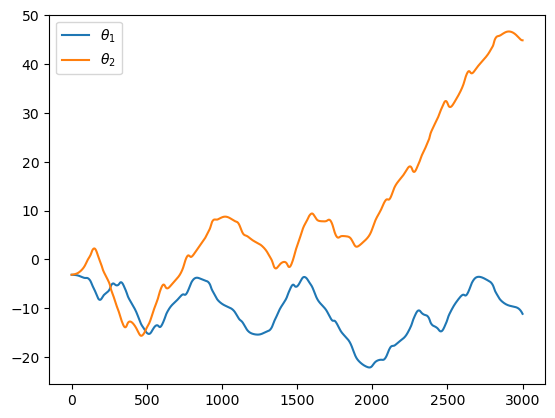

In [60]:
plt.plot(paths[0][:, 0], label=r'$\theta_1$')
plt.plot(paths[0][:, 2], label=r'$\theta_2$')
# plt.plot(paths[0][:, 1], label=r'x')
# plt.plot(paths[0][:, 3], label=r'y')
plt.legend()

In [71]:
noise = torch.randn_like(torch.tensor(paths[0]))

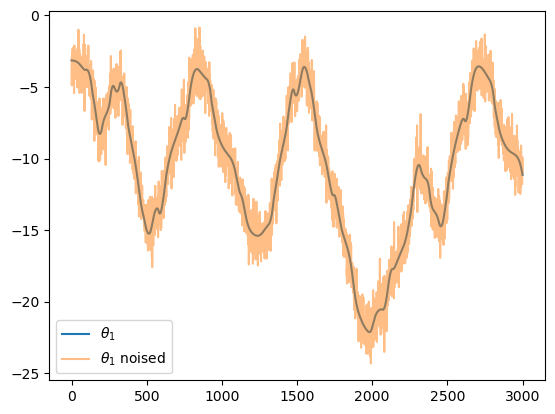

In [83]:
# plt.plot(noise[:, 0])
plt.plot(paths[0][:, 0], label=r'$\theta_1$')
plt.plot((torch.tensor(paths[0]) + noise)[:, 0], label=r'$\theta_1$ noised', alpha=0.5)
plt.legend()
plt.show()

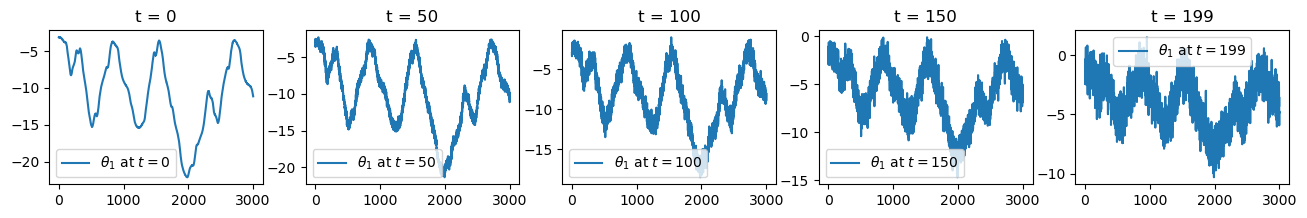

In [114]:
noise_levels = [0, 50, 100, 150, 199]
noised_path0 = [q_sample(torch.tensor(paths[0]), torch.tensor([t])) for t in noise_levels]
fig, axes = plt.subplots(1, len(noised_path0), figsize=(16, 2))

for ax, n_p, t in zip(axes, noised_path0, noise_levels):
    ax.plot(n_p[:, 0], label=fr'$\theta_1$ at $t={t}$')
    ax.legend()
    ax.set_title(f't = {t}')

/tmp/ipykernel_6441/3658665594.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


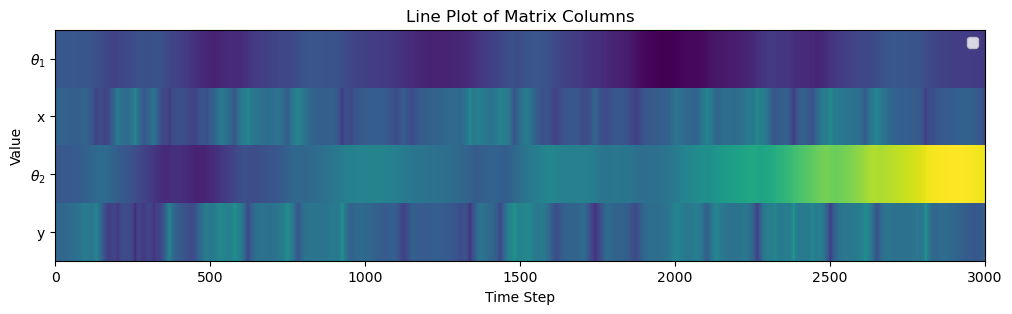

In [128]:
plt.figure(figsize=(12, 3))

plt.imshow(noised_path0[0].T, aspect='auto', interpolation='nearest')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Line Plot of Matrix Columns')
plt.legend()
plt.yticks(ticks=range(4), labels=[r'$\theta_1$', 'x', r'$\theta_2$', 'y'])
# plt.grid()
plt.show()

In [122]:
noised_path0[0].shape

torch.Size([3001, 4])